## Fabric: EfficientNetV2

In [2]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from copy import deepcopy

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')

y


In [4]:
# Sample Data
sample_train_data = pd.read_csv( '../data/train_sample_fabric.csv')
sample_val_data =  pd.read_csv( '../data/val_sample_fabric.csv')
sample_test_data =  pd.read_csv( '../data/test_sample_fabric.csv')

In [5]:
# Full Data
full_train_data = pd.read_csv( '../data/classification_train.csv')
full_val_data =  pd.read_csv( '../data/classification_val.csv')
full_test_data =  pd.read_csv( '../data/classification_test.csv')

In [6]:
class FashionDataset(Dataset):
    def __init__(self, data_frame, img_dir, label, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = data_frame
        self.img_dir = img_dir
        self.clothing_type = data_frame['clothing_type']
        self.label = data_frame[label]

        self.transform = transform            

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.label[idx]
        clothing_type = self.clothing_type[idx] 
        
        #Resize image and label to 572x572
        image = image.resize((572, 572))

        #Normalize the image
        image = np.asarray(image)
        min_image = np.min(image)
        max_image = np.max(image)
        image = (image - min_image)/(max_image - min_image + 1e-4)

        #Convert to tensors
        image = torch.tensor(np.array(image)).float().permute(2, 0, 1)
        label = torch.tensor(label).long()
        clothing_type = torch.tensor(clothing_type).long()
        sample = {'x': image, 'y': label, 'c': clothing_type}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
class EfficientNetV2(nn.Module):
    def __init__(self, num_classes=6):
        super(EfficientNetV2, self).__init__()
        self.efficientnet_v2 = models.efficientnet_v2_m(weights=None)
        num_ftrs = self.efficientnet_v2.classifier[-1].in_features
        self.efficientnet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.efficientnet_v2(x)

In [8]:
def train_model(model, dataloader, optimizer,  loss_fn, num_epochs = 10, verbose = False):
    f1_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_loss = np.inf
    best_f1 = 0
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            all_preds = []
            all_labels = []
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()            
                image = data['x'].to(device)
                label = data['y'].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(label.cpu().numpy())
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f} F1 {:.4f}'.format(p, epoch_loss, epoch_acc, epoch_f1))

            f1_dict[p].append(epoch_f1)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_f1 > best_f1:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_f1 = epoch_f1
                    best_model_wts = deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best model val acc: {:4f} Best model val F1: {:4f}'.format(best_acc, best_f1))
    
    model.load_state_dict(best_model_wts)
    
    return model, f1_dict, loss_dict


### Baseline Fabric Classification Model

In [9]:
bs = 8
efficientnetv2_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'fabric')}

efficientnetv2_dataloader = {x: DataLoader(efficientnetv2_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [10]:
efficientnetv2_model_fabric = EfficientNetV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnetv2_model_fabric.parameters(), lr=0.001)

efficientnetv2_model_fabric, efficientnetv2_f1_dict, efficientnetv2_loss_dict = train_model(efficientnetv2_model_fabric, 
                                                                     efficientnetv2_dataloader, 
                                                                     optimizer, 
                                                                     loss_fn=criterion, 
                                                                     num_epochs=10, 
                                                                     verbose=True)

Epoch: 0/9
----------
Phase:train, epoch loss: 1.0959 Acc: 0.6286 F1 0.1659
Phase:validate, epoch loss: 0.9831 Acc: 0.6160 F1 0.1554
Epoch: 1/9
----------
Phase:train, epoch loss: 0.9529 Acc: 0.6532 F1 0.2204
Phase:validate, epoch loss: 1.0188 Acc: 0.6156 F1 0.1270
Epoch: 2/9
----------
Phase:train, epoch loss: 0.9154 Acc: 0.6605 F1 0.2678
Phase:validate, epoch loss: 0.9090 Acc: 0.6583 F1 0.3271
Epoch: 3/9
----------
Phase:train, epoch loss: 0.8864 Acc: 0.6771 F1 0.2926
Phase:validate, epoch loss: 0.8869 Acc: 0.6628 F1 0.3562
Epoch: 4/9
----------
Phase:train, epoch loss: 0.8588 Acc: 0.6892 F1 0.3202
Phase:validate, epoch loss: 0.8442 Acc: 0.6931 F1 0.3731
Epoch: 5/9
----------
Phase:train, epoch loss: 0.8496 Acc: 0.6958 F1 0.3236
Phase:validate, epoch loss: 0.8461 Acc: 0.6920 F1 0.3632
Epoch: 6/9
----------
Phase:train, epoch loss: 0.8278 Acc: 0.7049 F1 0.3344
Phase:validate, epoch loss: 0.8937 Acc: 0.6767 F1 0.3771
Epoch: 7/9
----------
Phase:train, epoch loss: 0.8150 Acc: 0.7139 F1 

In [11]:
torch.save(efficientnetv2_model_fabric, 'fabric_classification_model_baseline_efficientnetv2.pth')

In [12]:
with open('fabric_classification_model_loss_dict_baseline_efficientnetv2.pkl', 'wb') as f:
    pickle.dump(efficientnetv2_loss_dict, f)

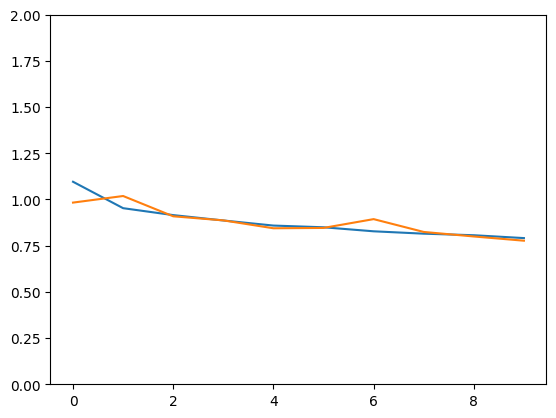

In [13]:
plt.plot(np.arange(0,10), efficientnetv2_loss_dict['train'])
plt.plot(np.arange(0,10), efficientnetv2_loss_dict['validate'])
plt.ylim(0,2);

In [10]:
efficientnetv2_model_fabric = torch.load('fabric_classification_model_baseline_efficientnetv2.pth')
optimizer = optim.Adam(efficientnetv2_model_fabric.parameters(), lr=0.001)

In [11]:
correct = 0
total = 0
efficientnetv2_model_fabric.eval()
for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

72.64993286132812


In [12]:
efficientnetv2_model_fabric.eval()
y_true = []
y_pred = []
probs = []

for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_fabric(image)
    softmax = nn.Softmax(dim=1)
    prob = softmax(output)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())
    probs.extend(prob.detach().cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
probs = np.array(probs)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], probs[:, i])
    auc_scores.append(auc)


# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)


Macro F1 score: 0.38284320650068887
One-vs-all AUC: 0.863701262295565


### Hyperparameter Tuning

In [9]:
batch_sizes = [8]
learning_rates = [0.00001, 0.0001, 0.001]

efficientnetv2_dataset = {'train': FashionDataset(sample_train_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'validate': FashionDataset(sample_val_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'test': FashionDataset(sample_test_data, '/vast/amr10211/cv_data/masked_images', 'fabric')}

f1_dicts = []
loss_dicts = []
val_auc = []
train_auc = []
val_f1 = []
train_f1 = []

for batch_size in batch_sizes:
    sample_dataloader = {x: DataLoader(efficientnetv2_dataset[x], batch_size=batch_size,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}
    
    lr_f1_dict = []
    lr_loss_dict = []
    lr_val_auc = []
    lr_train_auc = []
    lr_val_f1 = []
    lr_train_f1 = []
    
    for learning_rate in learning_rates:

        print('-'*50)
        print(f'learning rate={learning_rate} and batch_size={batch_size}')
        print('-'*50)

        tune_model = EfficientNetV2().to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(tune_model.parameters(), lr=learning_rate)

        tune_model_out, tune_f1_dict, tune_loss_dict = train_model(tune_model, 
                                                                    sample_dataloader, 
                                                                    optimizer, 
                                                                    loss_fn, 
                                                                    num_epochs=10, 
                                                                    verbose = True)
        
        lr_f1_dict.append(tune_f1_dict)
        lr_loss_dict.append(tune_loss_dict)
        
        # AUC for train dataset
        tune_model_out.eval()
        train_predictions = []
        train_targets = []
        for data in sample_dataloader['train']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)
            train_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            train_targets.extend(label.cpu().detach().numpy())

        train_auc_score = roc_auc_score(np.array(train_targets), np.array(train_predictions), average='macro', multi_class='ovr')
        train_f1_score = f1_score(np.array(train_targets), np.argmax(np.array(train_predictions), axis=1), average='macro')
        print(f'Train AUC for lr={learning_rate} and batch_size={batch_size}:\n{train_auc_score:.2f}')
        print(f'Train F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{train_f1_score:.2f}')
        lr_train_auc.append(train_auc_score)
        lr_train_f1.append(train_f1_score)
        

        # AUC for val dataset
        tune_model_out.eval()
        val_predictions = []
        val_targets = []
        for data in sample_dataloader['validate']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)

            val_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            val_targets.extend(label.cpu().detach().numpy())

        val_auc_score = roc_auc_score(np.array(val_targets), np.array(val_predictions), average='macro', multi_class='ovr')
        val_f1_score = f1_score(np.array(val_targets), np.argmax(np.array(val_predictions), axis=1), average='macro')
        print(f'Val AUC for lr={learning_rate} and batch_size={batch_size}:\n{val_auc_score:.2f}')
        print(f'Val F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{val_f1_score:.2f}')
        lr_val_auc.append(val_auc_score)
        lr_val_f1.append(val_f1_score)

    f1_dicts.append(lr_f1_dict)
    loss_dicts.append(lr_loss_dict)
    val_auc.append(lr_val_auc)
    train_auc.append(lr_train_auc)
    val_f1.append(lr_val_f1)
    train_f1.append(lr_train_f1)

with open('hyperparameter_sample_fabric_efficientnetv2.pkl', 'wb') as f:
    pickle.dump((f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1), f)

--------------------------------------------------
learning rate=1e-05 and batch_size=8
--------------------------------------------------
Epoch: 0/9
----------
Phase:train, epoch loss: 1.7529 Acc: 0.3427 F1 0.1498
Phase:validate, epoch loss: 1.7540 Acc: 0.6119 F1 0.1265
Epoch: 1/9
----------
Phase:train, epoch loss: 1.6832 Acc: 0.4234 F1 0.1608
Phase:validate, epoch loss: 1.6750 Acc: 0.5821 F1 0.1226
Epoch: 2/9
----------
Phase:train, epoch loss: 1.6174 Acc: 0.5323 F1 0.1395
Phase:validate, epoch loss: 1.6094 Acc: 0.6119 F1 0.1265
Epoch: 3/9
----------
Phase:train, epoch loss: 1.5550 Acc: 0.6230 F1 0.1405
Phase:validate, epoch loss: 1.5657 Acc: 0.6119 F1 0.1265
Epoch: 4/9
----------
Phase:train, epoch loss: 1.4815 Acc: 0.6250 F1 0.1484
Phase:validate, epoch loss: 1.5122 Acc: 0.6119 F1 0.1265
Epoch: 5/9
----------
Phase:train, epoch loss: 1.4293 Acc: 0.6310 F1 0.1290
Phase:validate, epoch loss: 1.4611 Acc: 0.6119 F1 0.1265
Epoch: 6/9
----------
Phase:train, epoch loss: 1.3660 Acc: 0.62

In [10]:
with open('hyperparameter_sample_fabric_efficientnetv2.pkl', 'rb') as f:
    f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1 = pickle.load(f)

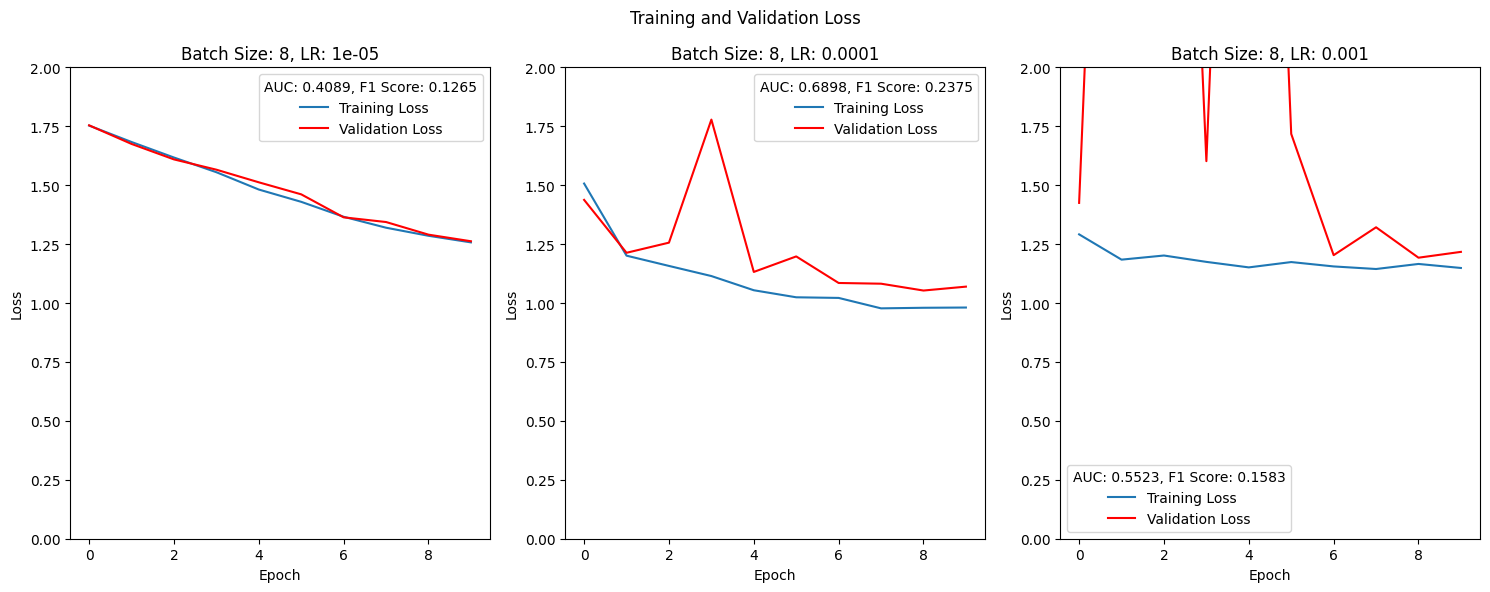

In [14]:
batch_sizes = [8]
learning_rates = [0.00001, 0.0001, 0.001] 

fig, axs = plt.subplots(len(batch_sizes), len(learning_rates), figsize=(15, 6))
plt.suptitle('Training and Validation Loss')

for i, batch_size in enumerate(batch_sizes):
    for j, learning_rate in enumerate(learning_rates):
        axs[j].plot(loss_dicts[i][j]['train'], label='Training Loss')
        axs[j].plot(loss_dicts[i][j]['validate'], label='Validation Loss', color='red')
        axs[j].set_title(f'Batch Size: {batch_size}, LR: {learning_rate}')
        axs[j].set_xlabel('Epoch')
        axs[j].set_ylabel('Loss')
        axs[j].set_ylim(0,2)
        axs[j].legend(title=f'AUC: {val_auc[i][j]:.4f}, F1 Score: {val_f1[i][j]:.4f}')

plt.tight_layout()
plt.savefig('hyperparameter_tuning_loss_fabric_efficientnetv2.png')
plt.show()

### Hyperparameter Tuned Fabric Classification Model

In [9]:
bs = 8
efficientnetv2_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'fabric')}

efficientnetv2_dataloader = {x: DataLoader(efficientnetv2_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [10]:
efficientnetv2_model_fabric = EfficientNetV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnetv2_model_fabric.parameters(), lr=0.0001)

efficientnetv2_model_fabric, efficientnetv2_f1_dict, efficientnetv2_loss_dict = train_model(efficientnetv2_model_fabric, 
                                                                     efficientnetv2_dataloader, 
                                                                     optimizer, 
                                                                     loss_fn=criterion, 
                                                                     num_epochs=10, 
                                                                     verbose=True)

Epoch: 0/9
----------
Phase:train, epoch loss: 0.9751 Acc: 0.6637 F1 0.2257
Phase:validate, epoch loss: 0.9085 Acc: 0.6864 F1 0.2888
Epoch: 1/9
----------
Phase:train, epoch loss: 0.8405 Acc: 0.7100 F1 0.3126
Phase:validate, epoch loss: 0.8047 Acc: 0.7111 F1 0.3856
Epoch: 2/9
----------
Phase:train, epoch loss: 0.8002 Acc: 0.7254 F1 0.3462
Phase:validate, epoch loss: 0.8346 Acc: 0.7085 F1 0.3621
Epoch: 3/9
----------
Phase:train, epoch loss: 0.7697 Acc: 0.7368 F1 0.3624
Phase:validate, epoch loss: 0.7686 Acc: 0.7194 F1 0.3692
Epoch: 4/9
----------
Phase:train, epoch loss: 0.7524 Acc: 0.7400 F1 0.3776
Phase:validate, epoch loss: 0.7411 Acc: 0.7385 F1 0.4138
Epoch: 5/9
----------
Phase:train, epoch loss: 0.7260 Acc: 0.7493 F1 0.4005
Phase:validate, epoch loss: 0.7668 Acc: 0.7179 F1 0.4792
Epoch: 6/9
----------
Phase:train, epoch loss: 0.7044 Acc: 0.7559 F1 0.4229
Phase:validate, epoch loss: 0.7429 Acc: 0.7325 F1 0.4801
Epoch: 7/9
----------
Phase:train, epoch loss: 0.6812 Acc: 0.7614 F1 

In [11]:
torch.save(efficientnetv2_model_fabric, 'fabric_classification_model_efficientnetv2.pth')

In [12]:
with open('fabric_classification_model_loss_dict_efficientnetv2.pkl', 'wb') as f:
    pickle.dump(efficientnetv2_loss_dict, f)

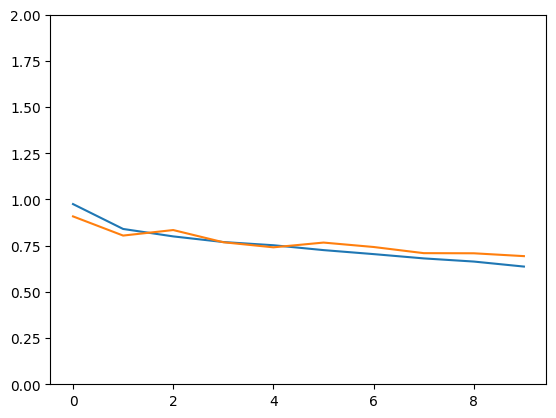

In [13]:
plt.plot(np.arange(0,10), efficientnetv2_loss_dict['train'])
plt.plot(np.arange(0,10), efficientnetv2_loss_dict['validate'])
plt.ylim(0,2);

In [14]:
correct = 0
total = 0
efficientnetv2_model_fabric.eval()
for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

77.11611938476562


In [15]:
efficientnetv2_model_fabric.eval()
y_true = []
y_pred = []

for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Calculate one-vs-all AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], y_pred == i)
    auc_scores.append(auc)

# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)


Macro F1 score: 0.5159819788356341
One-vs-all AUC: 0.7042263102704326


### 25 Epochs Tuned Fabric Classification Model

In [9]:
bs = 8

efficientnetv2_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'fabric')}

efficientnetv2_dataloader = {x: DataLoader(efficientnetv2_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [10]:
efficientnetv2_model_fabric = torch.load('fabric_classification_model_efficientnetv2.pth')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnetv2_model_fabric.parameters(), lr=0.0001)

efficientnetv2_model_fabric, efficientnetv2_f1_dict, efficientnetv2_loss_dict = train_model(efficientnetv2_model_fabric, 
                                                                     efficientnetv2_dataloader, 
                                                                     optimizer, 
                                                                     loss_fn=criterion, 
                                                                     num_epochs=15, 
                                                                     verbose=True)

Epoch: 0/14
----------
Phase:train, epoch loss: 0.6190 Acc: 0.7844 F1 0.5316
Phase:validate, epoch loss: 0.7135 Acc: 0.7329 F1 0.5086
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5907 Acc: 0.7915 F1 0.5494
Phase:validate, epoch loss: 0.6787 Acc: 0.7467 F1 0.5365
Epoch: 2/14
----------
Phase:train, epoch loss: 0.5702 Acc: 0.8003 F1 0.5755
Phase:validate, epoch loss: 0.6817 Acc: 0.7404 F1 0.5166
Epoch: 3/14
----------
Phase:train, epoch loss: 0.5408 Acc: 0.8068 F1 0.5969
Phase:validate, epoch loss: 0.6878 Acc: 0.7482 F1 0.5430
Epoch: 4/14
----------
Phase:train, epoch loss: 0.5070 Acc: 0.8178 F1 0.6239
Phase:validate, epoch loss: 0.6904 Acc: 0.7568 F1 0.5618
Epoch: 5/14
----------
Phase:train, epoch loss: 0.4748 Acc: 0.8292 F1 0.6510
Phase:validate, epoch loss: 0.6912 Acc: 0.7486 F1 0.5645
Epoch: 6/14
----------
Phase:train, epoch loss: 0.4423 Acc: 0.8434 F1 0.6853
Phase:validate, epoch loss: 0.7203 Acc: 0.7385 F1 0.5876
Epoch: 7/14
----------
Phase:train, epoch loss: 0.4104 Acc: 0.

In [11]:
torch.save(efficientnetv2_model_fabric, 'fabric_classification_model_25_epochs_efficientnetv2.pth')

In [12]:
with open('fabric_classification_model_loss_dict_25_epochs_efficientnetv2.pkl', 'wb') as f:
    pickle.dump(efficientnetv2_loss_dict, f)

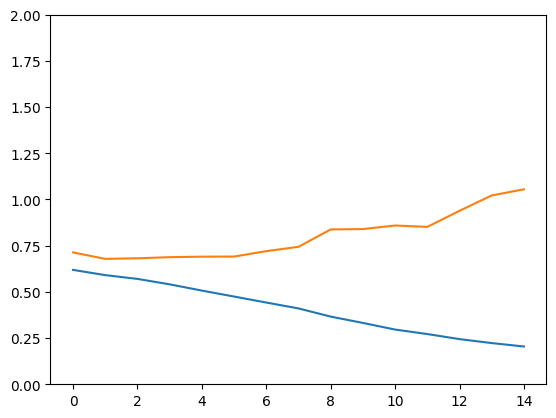

In [14]:
plt.plot(np.arange(0,15), efficientnetv2_loss_dict['train'])
plt.plot(np.arange(0,15), efficientnetv2_loss_dict['validate'])
plt.ylim(0,2);

In [13]:
efficientnetv2_model_fabric = torch.load('fabric_classification_model_25_epochs_efficientnetv2.pth')
optimizer = optim.Adam(efficientnetv2_model_fabric.parameters(), lr=0.0001)

In [14]:
correct = 0
total = 0
efficientnetv2_model_fabric.eval()
for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

76.98851776123047


In [15]:
efficientnetv2_model_fabric.eval()
y_true = []
y_pred = []
probs = []

for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_fabric(image)
    softmax = nn.Softmax(dim=1)
    prob = softmax(output)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())
    probs.extend(prob.detach().cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
probs = np.array(probs)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], probs[:, i])
    auc_scores.append(auc)


# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)


Macro F1 score: 0.5685209780002656
One-vs-all AUC: 0.9054511043816665


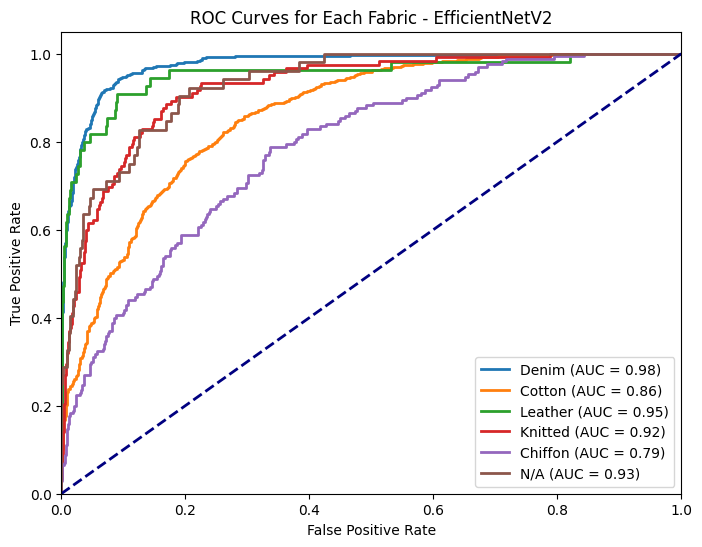

In [16]:
from sklearn.metrics import roc_curve, auc

# Define label mapping
label_mapping = {
    0: "Denim",
    1: "Cotton",
    2: "Leather",
    3: "Knitted",
    4: "Chiffon",
    5: "N/A"
}

# Plot class-level ROC curves
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_mapping[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fabric - EfficientNetV2')
plt.legend(loc="lower right")
plt.show()